# IMPORTANT NOTES TO READ BEFORE RUNNING THE NOTEBOOK

### The following instructions are related to the "notebook variables" section 

1. Determine the window size: **WIN_SIZE**
2. Determine the user name: **USER**
3. Determine whether to export labeled data (i.e., write to csv files)
4. Determine whether to save labeled figures
5. choose the dataset to import: **dataset_to_import**

# Intention Detection Study: Clustering Framework

In this notebook we use unsupervised clustering algorithms to label kinetic and kinematic measurements from different wheelchair maneuvers. Labeled data is exported and used for classification.   
- Exploring different window sizes and its effect on clustering 
- Exploring different numbers of clusters
- Exploring different feature subsets for clustering

## Importing relevant modules

In [1]:
import os
from os import path
import glob
import pathlib

import random 
import numpy as np
import pandas as pd

import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline  
import itertools
from scipy import linalg
import matplotlib as mpl
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

# importing relevant dimensionality reduction libraries
from sklearn.decomposition import PCA

# importing relevant clustering libraries
from sklearn.cluster import KMeans 
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import DBSCAN

# importing relevant clustering evaluation metrics
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances

###  Notebook variables

In [2]:
# choose dataset/datasets to import
datasets_to_import = ['Filtered_Data', 'Featured_Data', 'Feature_Extracted_Data']
dataset_to_import = datasets_to_import[2]

# determine window size
WIN_SIZE_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
WIN_SIZE = WIN_SIZE_list[4]

# determine the study participant
USER_list = ['Mahsa', 'Jaimie']
USER = USER_list[0]

# whether to save labeled data or not
SAVE_DATA = False
SAVE_LABELED_DATA_FIG = False

###  Notebook parameters

In [3]:
# list of all maneuvers
maneuvers = ['Obstacles15', 'Obstacles35', 'RampA', 'StraightF', 'Turn90FR', 'Turn90FL', 'Turn180L', 'Turn180R']

# choose the feature subsets for clustering
featureSet_list = ['ALL', 'ALL_TORQUE', '2D_TORQUE', 'LR_TORQUE', 'LR_TORQUE_MEAN', '2D_TORQUE_MEAN'] 

# path to save labeled data and corresponding figures
CURR_PATH = os.path.abspath('.')

In [4]:
# create a color pallette
cmap = matplotlib.cm.get_cmap('tab10')

list_of_colors = {'Lime':'#00FF00','Blue':'#0000FF', 'gold':'#FFD700', 'Gray': '#808080',
                  'orange red':'#FF4500', 'blue violet':'#8A2BE2', 'deep pink':'#FF1493',
                 'Olive':'#808000', 'red':'#FF0000', 'magenta':'#FF00FF', 'Black': '#000000',
                 'Purple':'#800080', 'dark turquoise':'#00CED1', 'forest green':'#228B22',
                 'lime green':'#32CD32'}
colors = {0:list_of_colors['lime green'], 1:list_of_colors['Blue'], 2:list_of_colors['gold'], 3:list_of_colors['Black'],
          4:list_of_colors['red'], 5:list_of_colors['Olive'], 6:list_of_colors['dark turquoise'], 
          7:list_of_colors['Gray'], 8:list_of_colors['Purple']}

## Part 1 -  Import processed data

### 1.1. Find csv files

In [5]:
# Glob all csv files in the folder
glob_paths = glob.glob(os.path.join(CURR_PATH, dataset_to_import, USER, 'WinSize'+ str(WIN_SIZE), '*.csv'))

# Choosing selected maneuvers for analysis
dataset_paths = [path for path in glob_paths if 'StraightF' in path or 'Turn90F' in path 
                 or 'Obstacles15' in path or 'Obstacles35' in path or 'RampA' in path or 'Turn180' in path]

### 1.2. Parsing data into Pandas

In [87]:
# Import datasets as a dictionary of Pandas DataFrames
datasets = {}

for dataset_path in dataset_paths:
    # Parse labels from filenames
    dataset_label = os.path.split(dataset_path)[1].split('.')[0]    

    # Read from csv to Pandas
    dataset = pd.read_csv(dataset_path)
    
    # insert dataset label to the dataframes
    dataset.insert(0, 'trial', dataset_label)
    dataset.insert(0, 'maneuver', dataset_label.split('_')[0])
    
    # Datasets are stored in a dictionary
    datasets.update({dataset_label: dataset})

# list of imported maneuvers
dataset_labels = list(datasets.keys())

# get columns/features of the imported datasets
data_columns =  [col for col in datasets[dataset_labels[0]].columns if col!='trial' 
                 and col !='Time' and col !='maneuver']

In [7]:
# # check imported dataframes
# display(datasets[dataset_labels[-1]].tail())
# print('Number of imported dataframes: {}'.format(len(dataset_labels)))
# print('\ndataset labeles: {}'.format(dataset_labels))

## Part 2 - Prepare dataframes for clustering 

- Concatenating all imported dataframes
- Dropping unused columns
- Standardizing features using **StandardScaler** 
- Creating a dictionary **(featureSet_dic)** consisting of lists of different feature sets including all features (ALL_FEAT), torque features (ALL_TORQUE), mean left/right torque (LR_TORQUE) 

### 2.1. Preparing dataframes: concat all maneuvers and standardize

In [8]:
#create an empty dataframe with columns similar to the imported datasets
df_all = pd.DataFrame(columns=datasets[dataset_labels[0]].columns.tolist())

# combine desired datasets into one dataframe
for label in dataset_labels:
    df_all = pd.concat([df_all, datasets[label]], ignore_index=True)

# keep a copy of the original dataframes before dropping the trial names
df_all_columns = df_all.copy()

# dropping unused columns/features
for col in ['Time', 'trial', 'maneuver']:
    if col in df_all.columns:
        df_all = df_all.drop(columns = [col])

        
columns_all = df_all.columns.tolist()
## create a list of toruqe features only
# all torque data
columns_torque = [col for col in df_all.columns.tolist() if 'Torque' in col]

# all torque features except for roc (mean/std/...  & left/right/sum/diff)
columns_2d_torque = [col for col in df_all.columns.tolist() if 'Torque_sum' in col or 'Torque_diff' in col and 'roc' not in col]

# all torque features of left and right only (mean/std/...  & left/right)
columns_lr_torque = [col for col in df_all.columns.tolist() if ('Torque_L' in col or 'Torque_R' in col) and 'roc' not in col]

# mean torque left and right only
columns_lr_torque_mean = ['Mean Torque_L','Mean Torque_R']

# mean torque left and right only
columns_2d_torque_mean = ['Mean Torque_sum','Mean Torque_diff']

# dictionary of list of feature subsets to be used for dimension_reduction or clustering
featureSet_dic = {'ALL': columns_all, 'ALL_TORQUE': columns_torque, 
                  '2D_TORQUE': columns_2d_torque, '2D_TORQUE_MEAN': columns_2d_torque_mean,
                  'LR_TORQUE': columns_lr_torque, 'LR_TORQUE_MEAN': columns_lr_torque_mean}
    
# normalize datasets: Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
feat_all_stand = scaler.fit_transform(df_all.values)
df_all_stand = pd.DataFrame(feat_all_stand, columns=data_columns)

In [9]:
# df_all_stand.tail()

In [10]:
# # examine scaled/original extracted features for all datasets
# featured_columns = ['AngVel_L', 'AngVel_R', 'Chair_LinVel', 'Chair_AngVel', 'Torque_L', 'Torque_R',
#                     'Torque_sum', 'Torque_diff', 'Torque_L_roc', 'Torque_R_roc']

# time_features = ['Mean', 'Std', 'Max', 'Min', 'RMS'] 

# for feat in featured_columns:  
#     for t_feat in time_features:
#         plt.plot(df_all_stand[t_feat + ' ' + feat], label = t_feat + '_normalized') 
#         plt.plot(df_all[t_feat + ' ' + feat], label = t_feat+ '_orig')
#         plt.legend()
#         plt.title(feat)
#         plt.show()

In [11]:
#  # examine scaled/original extracted features for all datasets
# featured_columns = ['AngVel_L', 'AngVel_R', 'Chair_LinVel', 'Chair_AngVel', 'Torque_L', 'Torque_R',
#                     'Torque_sum', 'Torque_diff', 'Torque_L_roc', 'Torque_R_roc']

# time_features = ['Mean', 'Std', 'Max', 'Min', 'RMS'] 

# fig, ax  = plt.subplots(5,2, figsize=(20, 40))
# ax = ax.ravel()
# k = 0
# for feat in featured_columns:  
#     for i, t_feat in enumerate(time_features):
#         ax[k].plot(df_all_stand[t_feat + ' ' + feat], label = t_feat, zorder=5-i)
#         ax[k].legend()
#         ax[k].set_title(feat)
        
#     k+=1

# plt.show()

In [12]:
# # examine sub-dataframes
# for feature in featureSet_list:
#     print(feature)
#     display(df_all_stand[featureSet_dic[feature]].head())

## Part 3 - PCA Analysis

### 3.1 PCA analysis to compare user assymetry

principle components of the left and right input torque Mahsa : 
 [[ 0.72898306  0.68453174]
 [ 0.68453174 -0.72898306]]


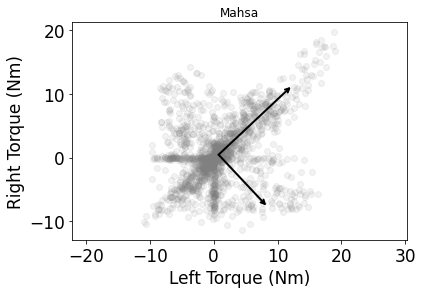

In [13]:
# PCA analysis for each user
df_PCA = df_all_columns.copy()
df_PCA = df_PCA[['Mean Torque_L', 'Mean Torque_R']]

# fit PCA 
pca = PCA(n_components=2).fit(df_PCA)

# print the pricinple components
print('principle components of the left and right input torque {} : \n {}'.format(USER, pca.components_))

# function to draw principle components in the form of vectors
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    ax.set_xlabel('Left Torque (Nm)', fontsize = 17)
    ax.set_ylabel('Right Torque (Nm)', fontsize = 17)
    ax.tick_params(direction='out', labelsize = 17)
    plt.title(USER)

# plot scatter plot of input torque overlaid with the pricinple component vectors
plt.scatter(df_PCA['Mean Torque_L'],df_PCA['Mean Torque_R'], alpha=0.1, c = 'Gray')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

principle components of the left and right input torque Mahsa : 
 [[ 0.9995059  -0.03143183]
 [-0.03143183 -0.9995059 ]]


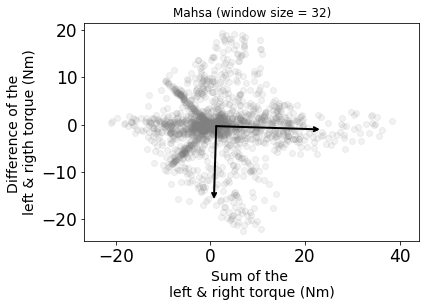

In [14]:
# PCA analysis for each user
df_PCA = df_all_columns.copy()
df_PCA = df_PCA[['Mean Torque_sum', 'Mean Torque_diff']]

# fit PCA 
pca = PCA(n_components=2).fit(df_PCA)

# print the pricinple components
print('principle components of the left and right input torque {} : \n {}'.format(USER, pca.components_))

# function to draw principle components in the form of vectors
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    ax.set_xlabel('Sum of the \nleft & right torque (Nm)', fontsize = 14)
    ax.set_ylabel('Difference of the \nleft & rigth torque (Nm)', fontsize = 14)
    ax.tick_params(direction='out', labelsize = 17)
    plt.title(USER + ' (window size = ' + str(WIN_SIZE) + ')')

# plot scatter plot of input torque overlaid with the pricinple component vectors
plt.scatter(df_PCA['Mean Torque_sum'],df_PCA['Mean Torque_diff'], alpha=0.1, c = 'Gray')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Part 4 - Clustering Models

### 4.1. Function to cluster the input dataframe with selected features

In [25]:
# clutering function for different model
feat_dropped = {}

def Clus_(df_all, cv_types, n_component_range, feat_subset_list):
    """
    function to cluster and evaluate the clustering performance
    input: dataframe consisting of different maneuvers to be clustered, feature sets to be used for clustering, 
           and the clustering model
    output: labeled dataframe and three performance measures 
    """
    gmm_models = {}
    
    lowest_bic = np.infty
#     bic = []
    
    labeled_datasets_dic = {}
    
    for feat_subset in feat_subset_list:
        
        df = df_all[featureSet_dic[feat_subset]].copy()
    
        X = df.values

        for cv_type in cv_types:
            for n_components in n_components_range:

                # Fit a Gaussian mixture with EM
                gmm = mixture.GaussianMixture(n_components=n_components,
                                              covariance_type=cv_type, 
                                              random_state = 1, 
                                              n_init = 10)
                gmm = gmm.fit(X)

                # predic labels & probabilities
                labels = gmm.predict(X)  
                labels_prob = gmm.predict_proba(X)

                # store gm models
                gmm_models.update({feat_subset + '_' + cv_type + '_' + str(n_components) : gmm})

#                 # store Bayesian information criterion score
#                 bic.append(gmm.bic(X))

#                 if bic[-1] < lowest_bic:
#                     lowest_bic = bic[-1]
#                     best_gmm = gmm


                # adding all droped features (for plotting purposes) of the standardized dataframe
                added_feat = [feat for feat in data_columns if feat not in df.columns]
                df[added_feat] = df_all_stand[added_feat].copy()
                df = df[data_columns]

                # adding the labels to the dataframe
                df.insert(0, 'Clus_label', labels)
                
                for n in range(n_components):
                    df['Prob_L'+str(n)] = labels_prob[:,n]

                labeled_datasets_dic.update({feat_subset + '_' + cv_type + '_' + str(n_components) :df})
    
    ## export all gmm models and a dictionary of all labeled datasets
    return gmm_models, labeled_datasets_dic

### 4.2. Train clustering models

In [26]:
## clustering model parameters
# determine covariance type [full, diagonal, tied, spherical]
covar_types = ['full'] 

# cluster number range
n_components_range = range(6, 7)

# create a list of feature subsets to examine clustering. Choose from **featureSet_list**
feat_list = ['ALL_TORQUE']

In [27]:
# run the cluster function
models, df_clus_dic = Clus_(df_all_stand.copy(),
                            covar_types,
                            n_components_range, feat_list)

In [76]:
models

{'ALL_TORQUE_full_6': GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                 means_init=None, n_components=6, n_init=10,
                 precisions_init=None, random_state=1, reg_covar=1e-06,
                 tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                 weights_init=None)}

### 4.3. Adding labels to original dataframe

In [29]:
# check labeled datasets
for label, df in df_clus_dic.items():
    print(label)
    display(df.tail())

ALL_TORQUE_full_6


,Clus_label,Mean AngVel_L,Std AngVel_L,Max AngVel_L,Min AngVel_L,RMS AngVel_L,Mean AngVel_R,Std AngVel_R,Max AngVel_R,Min AngVel_R,...,Std Torque_R_roc,Max Torque_R_roc,Min Torque_R_roc,RMS Torque_R_roc,Prob_L0,Prob_L1,Prob_L2,Prob_L3,Prob_L4,Prob_L5
2312,5,-1.267100,-0.804747,-1.297039,-1.247575,-1.429858,-1.254532,-0.787943,-1.283416,-1.231019,...,-0.196173,-0.242877,0.105565,-0.534601,7.827266e-242,0.000000e+00,0.0,4.284778e-11,9.212258e-80,1.000000e+00
2313,4,-1.309074,-0.639903,-1.323905,-1.287362,-1.472117,-1.279934,-0.976278,-1.310443,-1.248110,...,-0.402919,-0.448210,0.122463,-0.618962,9.700803e-124,0.000000e+00,0.0,1.013712e-14,1.000000e+00,3.420005e-09
2314,4,-1.324537,-1.075479,-1.358791,-1.289268,-1.492087,-1.301739,-0.789298,-1.327126,-1.276737,...,-0.575275,-0.452869,0.299479,-0.718318,1.858764e-95,2.549876e-282,0.0,2.171273e-15,1.000000e+00,1.445373e-09
2315,5,-1.323868,-1.013281,-1.358351,-1.293896,-1.490554,-1.325598,-0.928205,-1.355546,-1.295555,...,-0.499725,-0.381671,0.265724,-0.656843,1.527057e-59,1.348510e-215,0.0,1.288523e-08,2.867895e-02,9.713210e-01
2316,4,-1.341427,-0.925337,-1.368803,-1.311663,-1.478790,-1.340914,-1.027664,-1.373998,-1.305537,...,-0.498715,-0.430105,0.235332,-0.660257,1.602310e-32,1.396572e-136,0.0,2.314204e-14,1.000000e+00,1.155135e-08


In [33]:
df_labeled_dic = {}

for cluster_type, df_clus in df_clus_dic.items():
    
    # add all cluster labels to the original dataframe 
    df_all_labeled = df_all_columns.copy()
    df_all_labeled['Clus_label'] = df_clus['Clus_label'].copy()
    df_all_labeled['Clus_label']= df_all_labeled['Clus_label'].astype(int)
    for n in n_components_range:
        for i in range(0,n):
            df_all_labeled['Prob_L'+str(i)] = df_clus['Prob_L'+str(i)].copy()
    
    df_labeled_dic.update({cluster_type: df_all_labeled})

ALL_TORQUE_full_6


,maneuver,trial,Mean AngVel_L,Std AngVel_L,Max AngVel_L,Min AngVel_L,RMS AngVel_L,Mean AngVel_R,Std AngVel_R,Max AngVel_R,...,Max Torque_R_roc,Min Torque_R_roc,RMS Torque_R_roc,Clus_label,Prob_L0,Prob_L1,Prob_L2,Prob_L3,Prob_L4,Prob_L5
1478,Turn90FL,Turn90FL_T1_WS32_Mahsa,0.017789,0.004182,0.023159,0.009491,0.018274,0.009362,0.002737,0.014511,...,0.003159,-0.025435,0.011539,0,9.988667e-01,2.003705e-11,2.685368e-24,9.784689e-15,1.133306e-03,2.690723e-13
1479,Turn90FL,Turn90FL_T1_WS32_Mahsa,-0.003069,0.007146,0.008794,-0.014793,0.007777,0.008374,0.005708,0.014885,...,0.003199,-0.001418,0.002096,0,1.000000e+00,3.910374e-21,1.964117e-23,3.052288e-25,2.187808e-11,5.394302e-21
1480,Turn90FL,Turn90FL_T1_WS32_Mahsa,-0.019448,0.002615,-0.013125,-0.022427,0.019623,-0.017016,0.007662,-0.003228,...,0.001449,-0.005341,0.003066,0,1.000000e+00,1.766698e-17,7.949422e-34,1.805662e-23,4.756326e-10,8.955516e-21
1481,Turn90FL,Turn90FL_T1_WS32_Mahsa,0.020443,0.021947,0.060272,-0.011787,0.029993,-0.008591,0.020388,0.038619,...,0.091378,0.001537,0.044010,2,1.337858e-89,1.490219e-07,9.999999e-01,1.220889e-227,0.000000e+00,5.540761e-182
1482,Turn90FL,Turn90FL_T1_WS32_Mahsa,0.105782,0.026472,0.154799,0.063064,0.109044,0.128200,0.050755,0.212257,...,0.146532,0.096029,0.129652,2,0.000000e+00,1.178274e-171,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


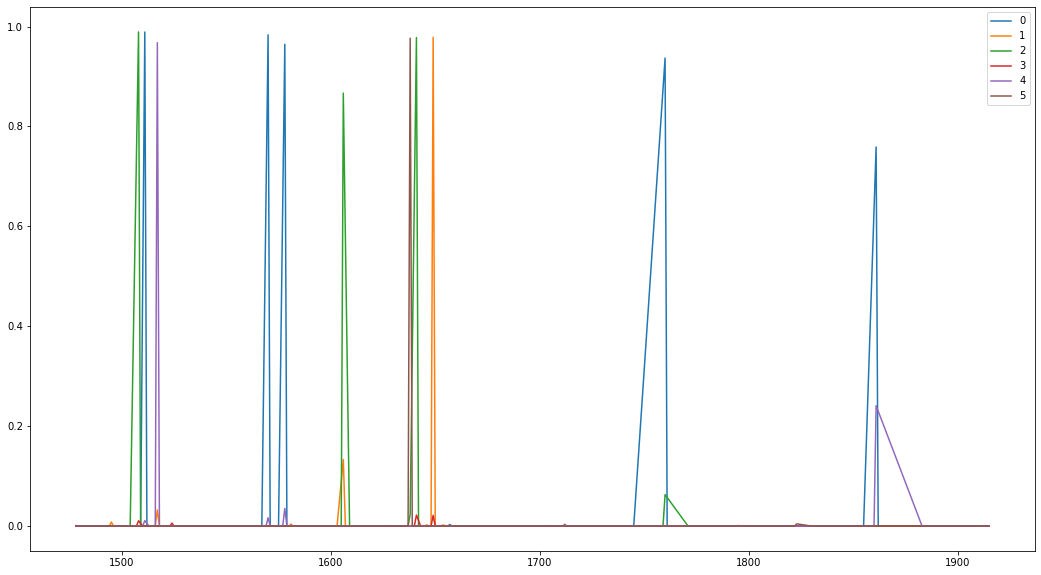

In [85]:
# check labeled datasets
for label, df in df_labeled_dic.items():
    print(label)
    df_test = df.loc[df['maneuver']=='Turn90FL'].copy()
    display(df_test.head())
    
    for n in n_components_range:
        plt.figure(figsize = (18, 10))
        color_ = [cmap(i) for i in range(n)]
        for i in range(0,n):
            df_subset = df_test.loc[(df_test['Prob_L'+str(i)] < 0.99) & (df_test['Prob_L'+str(i)] > 10^(-1))]
            plt.plot(df_subset['Prob_L'+str(i)], label = str(i), c = color_[i])
            
        plt.legend()
        plt.show()

## Part 5 - Evaluating clustering models

### 5.1. Plotting functions

In [47]:
# function to plot color-coded labeled data and cluster ellipoids
def plt_gm_clusters(df_all):
    
    ''' this function gets unlabeled scaled dataframe and predict labels + plotting cluster ellips'''
    
    color_iter = itertools.cycle([cmap(i) for i in range(cmap.N)])
    
    for label, clf in models.items(): 
        
        color_iter = itertools.cycle([cmap(i) for i in range(int(label[-1]))])
            
        df = df_all[featureSet_dic[label[:-7]]].copy()

        XX = df.values

        plt.figure(figsize=(8,6))
        
        splot = plt.subplot(1, 1, 1)
        
        # predict labels for each model
        Y_ = clf.predict(XX)
        
        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,color_iter)):
                    
            if "MEAN" in label:
                v, w = linalg.eigh(cov)
            else:
                
                subset = [0, 5]  # mean torque L & R
                v, w = linalg.eigh(cov[np.ix_(subset, subset)])
                mean = np.array([mean[0], mean[5]])
            
            if not np.any(Y_ == i):
                continue
                
            if "MEAN" in label:
                plt.scatter(XX[Y_ == i, 0], XX[Y_ == i, 1], color=color, s = 60)
            else:
                plt.scatter(XX[Y_ == i, 0], XX[Y_ == i, 5], color=color, s = 60)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180. * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(.5)
            splot.add_artist(ell)

        plt.xticks(())
        plt.yticks(())

        plt.title('Subject: {}, feature set: {}'.format(USER, label))
        plt.subplots_adjust(hspace=.35, bottom=.02)
        plt.show()

In [48]:
# function to plot color-coded labeled data and cluster ellipoids
def plt_gm_clusters_all(df_all):
    
    ''' this function gets unlabeled scaled dataframe and predict labels + plotting cluster ellips'''
    
    
    color_iter = itertools.cycle([cmap(i) for i in range(cmap.N)])
    
    fig, ax  = plt.subplots(len(feat_list),len(n_components_range), figsize = (15,15), constrained_layout=True)
    
    ax = ax.ravel()
    j = 0
    
    for label, clf in models.items(): 
        
        color_iter = itertools.cycle([cmap(i) for i in range(int(label[-1]))])
            
        df = df_all[featureSet_dic[label[:-7]]].copy()

        XX = df.values
        
        # predict labels for each model
        Y_ = clf.predict(XX)
                
        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,color_iter)):
                    
            if "MEAN" in label:
                v, w = linalg.eigh(cov)
                
            else:
                if 'ALL' in label and 'TORQUE' not in label:
                    subset = [20, 25]  # mean torque L & R
                    v, w = linalg.eigh(cov[np.ix_(subset, subset)])
                    mean = np.array([mean[20],mean[25]]) 
                else:
                    subset = [0, 5]  # mean torque L & R
                    v, w = linalg.eigh(cov[np.ix_(subset, subset)])
                    mean = np.array([mean[0],mean[5]]) 
                    
            if not np.any(Y_ == i):
                continue
                
            if "MEAN" in label:
                ax[j].scatter(XX[Y_ == i, 0], XX[Y_ == i, 1], color=color, s = 6)
            else:
                if 'ALL' in label and 'TORQUE' not in label:
                    ax[j].scatter(XX[Y_ == i, 20], XX[Y_ == i, 25], color=color, s = 6)
                else:
                    ax[j].scatter(XX[Y_ == i, 0], XX[Y_ == i, 5], color=color, s = 6)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180. * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(ax[j].bbox)
            ell.set_alpha(.5)
            ax[j].add_artist(ell)
            ax[j].set_title(label)
            ax[j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax[j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            
        j+=1
    plt.suptitle(USER + "_" + str(WIN_SIZE))    
    plt.show()

In [49]:
# finding the index range for each maneuver
def range_dic_(df_):
    """
    get the start index of each maneuver from the original dataframe
    """
    range_dic = {}
    for man in df_['maneuver']:
        trial_indx = df_.index[df_['maneuver'] == man].tolist()
        range_ = (min(trial_indx), max(trial_indx))
        range_dic.update({man:range_})
    return range_dic

In [50]:
# function to plot clusters in time series data
def plt_ts_cluster(df_dic, features_to_plot):
    """
    input: input original dataframe (with maneuver columns), clustered dataframe, number of clusteres, 
           and selected features to plot
    output: plotting clustered time series data with different colors
    """
    
    for label, df_ in df_dic.items():
        
        df_clus = df_.copy()    
                
        plt_num = 2

        fig, axs = plt.subplots(plt_num, 1, figsize= (15,12), constrained_layout=True)
        axs = axs.ravel()

        states = df_clus['Clus_label']
        
        clusterNum = int(label[-1])

        color_dict = {i:cmap(i) for i in range(clusterNum)}
        color_array = [color_dict[i] for i in states]
        
        for i, feature in enumerate(features_to_plot):
            axs[i].scatter(df_clus.index, df_clus[feature], c=color_array, s = 10)
            axs[i].set_xlim([-1, len(df_clus)+1])
            axs[i].tick_params(direction='out', labelsize = 15)
            axs[i].yaxis.grid(True)

            if 'Torque' in feature:
                axs[i].set_ylabel(feature+ ' (Nm)', fontsize=15)
            elif 'Lin' in feature:
                axs[i].set_ylabel(feature+ ' (m/s)', fontsize=15)
            elif 'Ang' in feature:
                axs[i].set_ylabel(feature+ ' (rad/s)', fontsize=15)
                
        fig.suptitle(label, fontsize=16)

        range_dic = range_dic_(df_clus)

        
        for trial, range_ in range_dic.items():    
            axs[0].text(range_[0], axs[0].get_ylim()[1]+0.2, trial, fontsize = 15, rotation=45)
            for i in range(plt_num):
                axs[i].axvline(x=range_[0], linestyle='--', linewidth=0.5)


        plt.show()

In [61]:
# function to plot clusters in time series data
def plt_ts_cluster_subset(df_dic, features_to_plot, man_list = maneuvers):
    """
    input: input original dataframe (with maneuver columns), clustered dataframe, number of clusteres, 
           and selected features to plot
    output: plotting clustered time series data with different colors
    """
    
    for label, df_ in df_dic.items():
        
        clusterNum = int(label[-1])
        color_dict = {i:cmap(i) for i in range(clusterNum)}
        
        if WIN_SIZE == 128: 
            figsize = (10,15)
            legend_size = 12
        elif WIN_SIZE == 64:
            figsize = (10,15)
            legend_size = 12
        else:
            figsize = (15,15)
            legend_size = 1
        
        if len(man_list) == 1:
            figsize = (15,8)
        
        fig, axs = plt.subplots(len(man_list), 1, figsize= figsize, constrained_layout=True)
        fig.suptitle(label, fontsize=16)
        
        if len(man_list) != 1:
            axs = axs.ravel()
        i = 0
        
        for i, wheelchair_man in enumerate(man_list):

            df_clus = df_.loc[df_['maneuver'] == wheelchair_man].copy()
            df_clus = df_clus.reset_index()
            
            states = df_clus['Clus_label']
            color_array = [color_dict[i] for i in states] 
            
            if len(man_list) != 1:
        
                axs[i].scatter(df_clus.index, df_clus[features_to_plot[0]], c=color_array, s = 16)
                axs[i].scatter(df_clus.index, df_clus[features_to_plot[1]], c=color_array, s = 16, alpha = 0.7, marker = '>')

                axs[i].tick_params(direction='out', labelsize = 15)
                axs[i].set_ylabel('Torque (Nm)', fontsize=15)
                axs[i].set_title(wheelchair_man)
                axs[i].yaxis.grid(True)
                axs[i].set_xlim([-1, len(df_clus)+1])


                legend_elements = [Line2D([0], [0], marker='>', color='w', label='Right', markerfacecolor='k', markersize=15), 
                                   Line2D([0], [0], marker='o', color='w', label='Left', markerfacecolor='k', markersize=15)]
                axs[i].legend(handles=legend_elements, fontsize = legend_size)
            
            else:
                axs.scatter(df_clus.index, df_clus[features_to_plot[0]], c=color_array, s = 16)
                axs.scatter(df_clus.index, df_clus[features_to_plot[1]], c=color_array, s = 16, alpha = 0.7, marker = '>')

                axs.tick_params(direction='out', labelsize = 15)
                axs.set_ylabel('Torque (Nm)', fontsize=15)
                axs.set_title(wheelchair_man)
                axs.yaxis.grid(True)
                axs.set_xlim([-1, len(df_clus)+1])


                legend_elements = [Line2D([0], [0], marker='>', color='w', label='Right', markerfacecolor='k', markersize=15), 
                                   Line2D([0], [0], marker='o', color='w', label='Left', markerfacecolor='k', markersize=15)]
                axs.legend(handles=legend_elements, fontsize = legend_size)

            
        plt.show()

### 5.2. Evaluated clustering outcome

In [ ]:
## uncomment if you want to compare different covariance types
# bic = np.array(bic_score)
# color_iter = itertools.cycle(['b', 'g', 'orchid',
#                               'darkorange', 'firebrick', 'indigo', 'lime', 'teal'])
# clf = models[-3]
# bars = []

# # Plot the BIC scores
# plt.figure(figsize=(10, 10))
# spl = plt.subplot(2, 1, 1)
# for i, (cv_type, color) in enumerate(zip(covar_types, color_iter)):
#     xpos = np.array(n_components_range) + .2 * (i - 2)
#     bars.append(plt.bar(xpos, bic[i*len(n_components_range):(i + 1)*len(n_components_range)], width=.2, color=color))
    
# plt.xticks(n_components_range)
# plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
# plt.title('BIC score per model')
# xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +  .2 * np.floor(bic.argmin() / len(n_components_range))
# # plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
# spl.set_xlabel('Number of components')
# spl.legend([b[0] for b in bars], covar_types);

In [45]:
## plotting all labeled data in a time series format
# plt_ts_cluster(df_labeled_dic, ['Mean Torque_L', 'Mean Torque_R'])

In [ ]:
plt_gm_clusters_all(df_all_stand.copy())

### 5.5. Functions to plot clustered dataframes

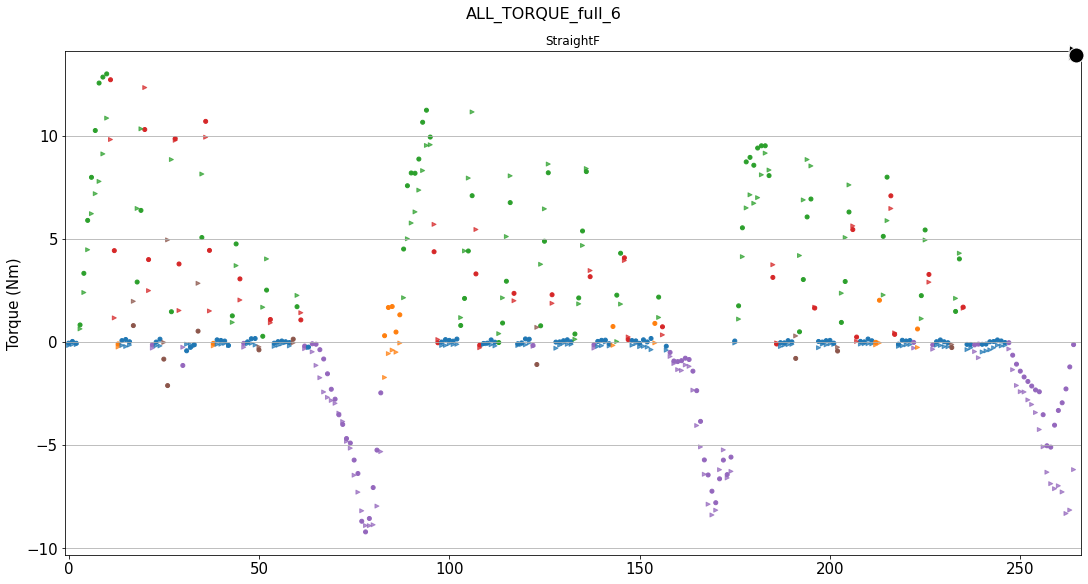

In [62]:
## plotting a subset of selected labeled maneuvers in a time series format
plt_ts_cluster_subset(df_labeled_dic,['Mean Torque_L','Mean Torque_R'],['StraightF'])

In [ ]:
# ## plotting a subset of selected labeled maneuvers in a time series format
# plt_ts_cluster_subset(df_labeled_dic,['Mean Torque_L','Mean Torque_R'])

## 7. Save labeled/relabeled dataset & clustering model

In [81]:
SAVE_DATA = True
# saving labeled datasets
if SAVE_DATA:
    # save the clustering model
    for name, model in models.items():
        model_path = os.path.join(CURR_PATH, 'Clustering_Models', USER, str(WIN_SIZE))
        pathlib.Path(model_path).mkdir(parents=True, exist_ok=True)
        
        modelname = name + '.sav'
        modelname = os.path.join(model_path, modelname)
        pickle.dump(model, open(modelname, 'wb'))

        # save labeled dataset
        processed_path = os.path.join(CURR_PATH, 'Labeled_Data', USER, str(WIN_SIZE))
        pathlib.Path(processed_path).mkdir(parents=True, exist_ok=True)
        filename = name  + '.csv'
        filename = os.path.join(processed_path, filename)
        df_labeled_dic[name].to_csv(filename, index=False)
    
else:
    print('"***WARNING*** \n DATASETS + CLUSTERING MODEL WERE NOT SAVED')